# Exploratory data analysis

In this notebook, we are going to do EDA to better understand the nature of our data. Since we already split the dataset into folds, we're only going to perform EDA on the train set of a single fold; the EDA result should be applicable to the other folds.

In [31]:
import sys
sys.path.insert(0, '..')

from collections import Counter
import math
import os
import random

import matplotlib.pyplot as plt
import numpy as np

from utils import CorpusReader

plt.style.use('ggplot')
%matplotlib inline

In [3]:
data_dir = os.path.join('..', 'data', 'working', '2018-04-21', 'idn-tagged')

reader = CorpusReader(os.path.join(data_dir, 'train.01.tsv'), lower=False, replace_digits=False)

In [27]:
def plot_dist(data, name, bins=None):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.hist(data, bins=bins)
    plt.xlabel(name)
    plt.subplot(122)
    plt.boxplot(data)
    plt.ylabel(name)
    plt.xticks([])

In [8]:
def create_outlier_detector(data):
    q1, q3 = np.percentile(data, (25, 75))
    def is_outlier(x):
        iqr = q3 - q1
        return x < q1 - 1.5*iqr or x > q3 + 1.5*iqr
    return is_outlier

## Sentence length distribution

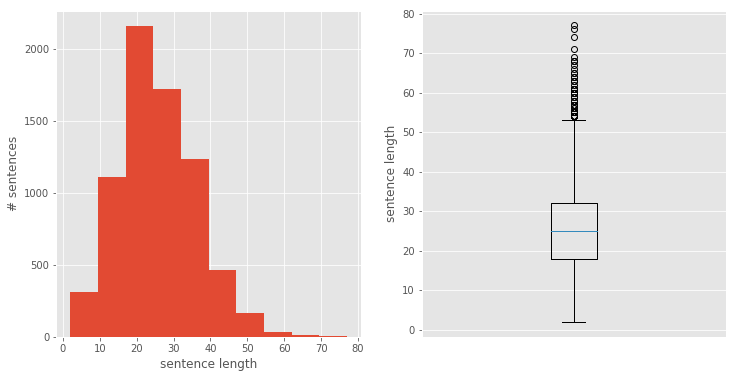

In [6]:
sent_lengths = [len(sent) for sent in reader.sents()]
plot_dist(sent_lengths, 'sentence length')

The sentence length distribution is rather right-skewed and from the boxplot we see that there are quite a few outliers. Let's see what these outliers are.

In [9]:
is_outlier = create_outlier_detector(sent_lengths)
outlier_sents = [sent for sent in reader.sents() if is_outlier(len(sent))]

In [10]:
len(outlier_sents)

61

In [13]:
for sent in random.choices(outlier_sents, k=5):
    print(' '.join(sent), end='\n\n')

Berdasarkan usulan pinjaman yang diajukan sebelum -nya , kata Benny , penyerapan pinjaman terbesar pada 2008 diberikan oleh JBIC sebesar 775,1 juta dolar AS 37 proyek , Bank Dunia 708,3 juta dolar AS 37 proyek , ADB 608,5 juta dolar AS 40 proyek , lembaga donor lain -nya Bank Pembangunan Islam / IDB dan Dana Internasional untuk Pembangunan Pertanian / IFAD 132,2 juta dolar AS 17 proyek .

Pertemuan dua hari yang berlangsung di Doha , disponsori oleh Komite Pelatihan Hak-hak Yang Tak Bisa Dicabut dari Rakyat Palestina , adalah merupakan pintu masuk bagi krisis sosial ekonomi dan kemanusiaan di wilayah Palestina yang diduduki , meninjau kembali tanggapan internasional dan regional tentang keinginan-keinginan rakyat Palestina , serta menjajaki cara-cara untuk menjamin pemulihan ekonomi bangsa Palestina .

Sebagai langkah awal , Agri Resources BV belum lama ini telah merealisasikan aksi akuisisi atas suatu kelompok usaha perkebunan yang memiliki lahan kebun di Sumatera Bagian Selatan denga

The outlier sentences are all valid news sentences. Although it is tempting to discard or truncate these outliers, we think it is better to leave them as they are. Later though, we can analyze the tagger performance on, say, different levels of sentence length e.g. short sentences (fewer than 50 words) vs long sentences.

## POS tag distribution

In [18]:
c = Counter(tag for _, tag in reader.tagged_words())
len(c)

23

In [19]:
c.most_common(10)

[('NN', 44672),
 ('NNP', 24845),
 ('VB', 22790),
 ('Z', 18862),
 ('IN', 15371),
 ('CD', 12758),
 ('SC', 9366),
 ('JJ', 6997),
 ('PRP', 5408),
 ('CC', 5322)]

Unsurprisingly, the most common POS tags are nouns, followed by verbs and punctuations. Let's plot the whole distribution.

<BarContainer object of 23 artists>

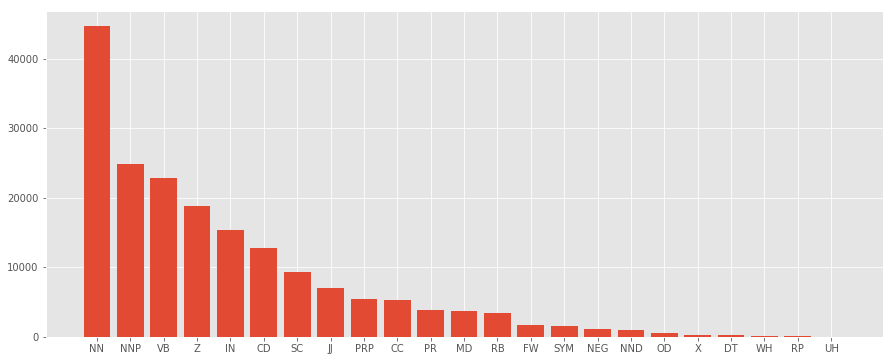

In [22]:
tags, counts = zip(*c.most_common())
plt.figure(figsize=(15, 6))
plt.bar(range(len(tags)), counts, tick_label=tags)

We see that the POS tags are imbalanced. We have a very high number for `NN` but then going to the left, the occurrence goes down quickly and we end up with only a handful number of `NND`, `OD`, etc. This might pose a problem. Some ways to deal with this imbalanced data is undersampling the majority or oversampling the minority. Before deciding on which way to go, let's plot the tag counts distribution first.

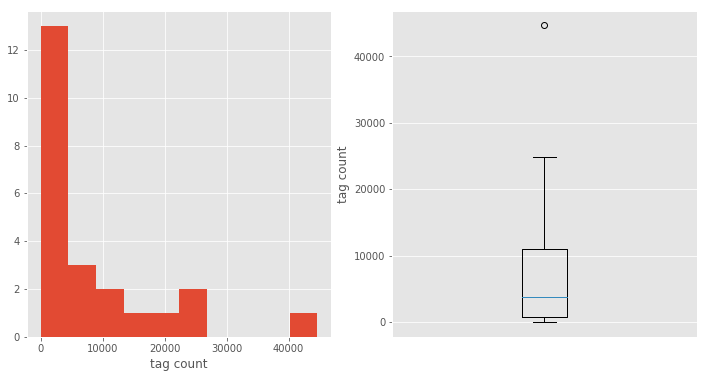

In [30]:
plot_dist(counts, 'tag count')

It seems that the outlier is `NN` tag here. It may make more sense to undersample sentences containing this tag.

In [32]:
def undersample(tagged_sents, majority_tag='NN', rate=0.1):
    majority, rest = [], []
    for tagged_sent in tagged_sents:
        for _, tag in tagged_sent:
            if tag == majority_tag:
                majority.append(tagged_sent)
                break
        else:
            rest.append(tagged_sent)
    n_sample = math.floor(len(majority) * rate)
    undersampled = random.choices(majority, k=n_sample)
    for ts in undersampled:
        rest.append(ts)
    random.shuffle(rest)
    return rest

In [33]:
dataset = undersample(reader.tagged_sents())

<BarContainer object of 23 artists>

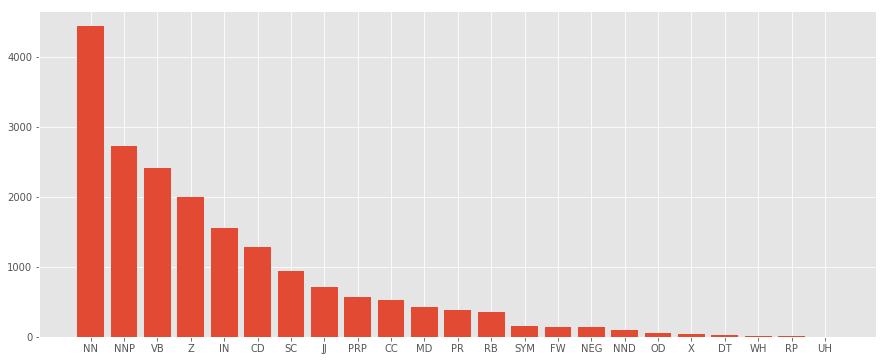

In [34]:
c = Counter(tag for tagged_sent in dataset for _, tag in tagged_sent)
tags, counts = zip(*c.most_common())
plt.figure(figsize=(15, 6))
plt.bar(range(len(tags)), counts, tick_label=tags)

The distribution still look the same! This is not surprising when I think about it. When we undersample, we remove sentences containing the majority tag. But that sentence contains other tags as well. So, the counts for the other tags also decrease. Thus, undersampling/oversampling does not seem to suit well for this task.

What else can we do? I think we can instead use the right performance measure. If we use accuracy, a model that only predict the majority class would have a high score. F1 score is a much better alternative as it takes into account the precision and recall of the model. Specifically, weighted macro-averaged F1 score is what I think best. Macro-averaged because for POS tagging, micro-averaged F1 score equals accuracy. Weighted because we do not want to be penalized for wrongly predicting infrequent tags like `RP` or `UH`. Fortunately, this scoring function is already provided by `scikit-learn`.